# Traffic sign recognition - Nerual Net

In [0]:
import numpy as np
np.random.seed(123)  # for reproducibility

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

from sklearn import model_selection

from matplotlib import pyplot as plt
from imageio import imread # Need 'Imageio' 'Pillow' packages
import cv2

from math import floor, ceil
import os

import h5py

# Run this if on Colab

In [4]:
import tensorflow as tf

# Checking GPU support
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzipping the data
!unzip /content/drive/My\ Drive/German_traffic_sign_dataset.zip #-d path_to_directory /content/German_traffic_sign_dataset

Streaming output truncated to the last 5000 lines.
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00000.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00001.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00002.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00003.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00004.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00005.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00006.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00007.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00010.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00013.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_00015.ppm  
  inflating: German traffic sign dataset/GTSRB_Training/00035/00001_0

## Load data from German traffic sign database

In [8]:
# Use this if local
main_folder_path = "./German traffic sign dataset" + "/GTSRB_Training" + "/"
# Use this if Colab
main_folder_path = "/content/German traffic sign dataset" + "/GTSRB_Training" + "/"

csv_content = [] # One numpy array per folder
                 # Each numpy array x: image y: proprierties

# Iterate over all subfolders to read the CSV file of each class
for i in range(43):
    train_dataset_path = main_folder_path + "{:05.0f}".format(i) + "/"
    f_name = train_dataset_path + "GT-" + "{:05.0f}".format(i) + ".csv"
    csv_content.append(np.genfromtxt(f_name, delimiter=';', skip_header=1, dtype=str))
print(csv_content[0][1,:])

['00000_00001.ppm' '30' '30' '5' '5' '25' '25' '0']


In [0]:
# Load the images and respective class

image = []
img_num = 0
labels = np.empty(0)

for i in range(43):
    image_class = []
    train_dataset_path = main_folder_path + "{:05.0f}".format(i) + '/'
    for label_name in enumerate(csv_content[i][:,0]):
        image_class.append(imread(train_dataset_path + label_name[1])[:,:,0]) # Adding image
        labels = np.append(labels, i) # Appending image class based on folder
        img_num += 1
    image.append(image_class)

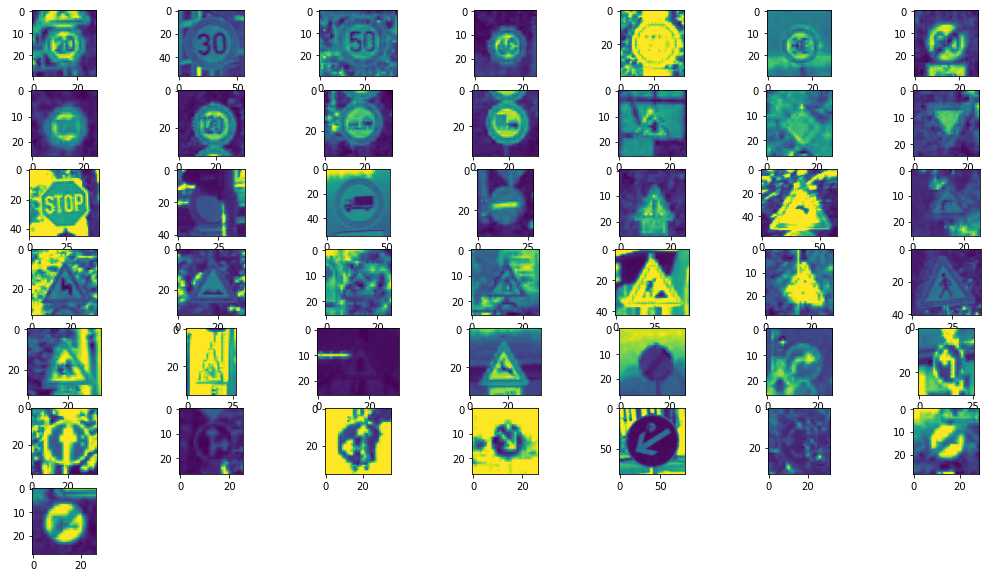

In [10]:
# Print the first image in every class
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(nrows=7, ncols=7)

for i in enumerate(image):
    ax0 = fig.add_subplot(gs[i[0]//7, i[0]%7])
    ax0.imshow(i[1][0])
    
plt.show()

<function matplotlib.pyplot.show>

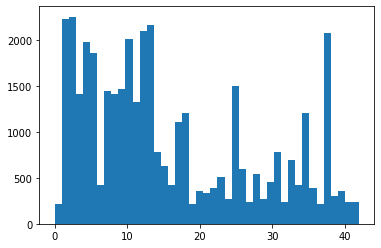

In [11]:
# Histogram of class population
plt.hist(labels, len(image))
plt.show

## Adapting the images

In [0]:
# Reshape training set
x_size = 32
y_size = 32
img_train = np.empty((img_num, x_size, y_size))

elaborated = 0

for image_set in enumerate(image):
    for image_array in enumerate(image_set[1]):
        # Cutting the image to match the content
        x2 = int(csv_content[image_set[0]][image_array[0], 5]) 
        x1 = int(csv_content[image_set[0]][image_array[0], 3])
        y2 = int(csv_content[image_set[0]][image_array[0], 6]) 
        y1 = int(csv_content[image_set[0]][image_array[0], 4])
        size = max(x2-x1, y2-y1)
        # Padding to have square images
        padded = np.pad(np.asarray(image_array[1][x1:x2, y1:y2]), \
                        ((floor((size-x2+x1)/2), ceil((size-x2+x1)/2)),\
                         (floor((size-y2+y1)/2), ceil((size-y2+y1)/2))))
        # Reshaping the image to match the selected dimension
        reshaped = cv2.resize(padded, (x_size, y_size), interpolation = cv2.INTER_AREA)
        # Copying the image inside the output array
        np.copyto(img_train[elaborated,:,:], reshaped)
        # Showing result
        #plt.imshow(img_train[elaborated,:,:])
        #plt.show()
        #Images should be one after another to train the model
        elaborated += 1

In [13]:
# Reshaping the train data to have a correct fit input
print(img_train.shape)
img_train_rsh = np.reshape(img_train, (img_train.shape[0], img_train.shape[1], img_train.shape[2],1))
print(img_train_rsh.shape)

(39209, 32, 32)
(39209, 32, 32, 1)


In [14]:
# Split train and validation data from the train dataset
x_train, x_test, y_train, y_test = model_selection.train_test_split(img_train_rsh, labels, test_size=0.25)
print(x_train.shape[0], x_test.shape[0], y_train.shape[0], y_test.shape[0])

29406 9803 29406 9803


In [15]:
# Prepare ground truth for classification
print(y_train.shape)
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = to_categorical(y_train, len(image))
Y_test = to_categorical(y_test, len(image))
print(Y_train.shape)

(29406,)
(29406, 43)


## Exhaustive search over different models

In [16]:
results = np.empty((0,12))

for i in enumerate([10, 50, 100, 150, 200]):
    for j in enumerate([0, 10, 50, 100, 150, 200]):
        for f in enumerate([0, 10, 50, 100, 150, 200]):
            for a in enumerate([50, 100, 200, 300, 400]):
                current_test = i[0]*180+j[0]*30+f[0]*5+a[0]
                print("Test {}/900 initialized...".format(int(current_test+1)))
                
                temp = np.zeros((12))
                
                prev_conv = i[1]
                out_dim = x_size
                model = Sequential()
                
                model.add(Conv2D(i[1], (7,7), strides=(1,1), activation='relu'))
                temp[1] = (7*7+1)*i[1]
                out_dim -= 6
                
                model.add(MaxPooling2D(pool_size=(2,2)))
                out_dim = ceil(out_dim/2)
                
                if j[1]:
                    model.add(Conv2D(j[1], (4,4), strides=(1,1), activation='relu'))
                    temp[2] = (4*4*prev_conv+1)*j[1]
                    out_dim -= 3
                    
                    model.add(MaxPooling2D(pool_size=(2,2)))
                    out_dim = ceil(out_dim/2)
                    prev_conv = j[1]
                    
                if f[1]:
                    model.add(Conv2D(f[1], (4,4), strides=(1,1), activation='relu'))
                    temp[3] = (4*4*prev_conv+1)*f[1]
                    out_dim -= 3
                    
                    model.add(MaxPooling2D(pool_size=(2,2)))
                    out_dim = ceil(out_dim/2)
                    prev_conv = f[1]
                    
                model.add(Flatten())
                model.add(Dense(a[1], activation='relu'))
                temp[4] = (prev_conv*(out_dim**2)+1)*a[1]
                model.add(Dense(43, activation='softmax'))
                temp[5] = (a[1]+1)*43
                
                es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
                
                model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
                model.fit(x_train, Y_train, validation_split=0.2, batch_size=50, epochs=20, verbose=0, callbacks=[es])

                test_loss, test_acc = model.evaluate(x_test, Y_test, verbose=0)
                
                temp[8] = i[1]
                temp[9] = j[1]
                temp[10] = f[1]
                temp[11] = a[1]
                
                temp[0] = model.count_params()
                temp[6] = test_acc
                temp[7] = test_loss

                # Weight of the conv layers: last filter size times the maps plus the bias for each filter of layer 
                # Weight of the conv layers: input size times output size plus bias for output fully connected layer
                # Must track the last convolutional layer dimension in to not have any zeros and must track
                # the size of the conv output layer to take into account the Flatten() output layer dimension
                
                results = np.append(results, np.reshape(temp, (1, -1)), axis=0)
            
                print(results[current_test, :])
                #print(model.summary())
                #print('\nTest accuracy:', test_acc)
                #print('\nModel size:', computed_size*4)
                #print('\nModel size compressed:', computed_size)

Test 1/900 initialized...
[8.72430000e+04 5.00000000e+02 0.00000000e+00 0.00000000e+00
 8.45500000e+04 2.19300000e+03 8.23421419e-01 7.54528292e-01
 1.00000000e+01 0.00000000e+00 0.00000000e+00 5.00000000e+01]
Test 2/900 initialized...
Epoch 00015: early stopping
[1.73943000e+05 5.00000000e+02 0.00000000e+00 0.00000000e+00
 1.69100000e+05 4.34300000e+03 9.25941050e-01 6.19126663e-01
 1.00000000e+01 0.00000000e+00 0.00000000e+00 1.00000000e+02]
Test 3/900 initialized...
Epoch 00010: early stopping
[3.47343000e+05 5.00000000e+02 0.00000000e+00 0.00000000e+00
 3.38200000e+05 8.64300000e+03 9.01968777e-01 6.53579630e-01
 1.00000000e+01 0.00000000e+00 0.00000000e+00 2.00000000e+02]
Test 4/900 initialized...
Epoch 00010: early stopping
[5.20743000e+05 5.00000000e+02 0.00000000e+00 0.00000000e+00
 5.07300000e+05 1.29430000e+04 9.08905447e-01 6.97784155e-01
 1.00000000e+01 0.00000000e+00 0.00000000e+00 3.00000000e+02]
Test 5/900 initialized...
Epoch 00008: early stopping
[6.94143000e+05 5.0000

## Writing results on file

In [0]:
np.savetxt("/content/Model_Comparison_Results.csv", results, delimiter = ',', fmt = '%f')